In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images = train_images.reshape((60000, 28*28,))
train_images = train_images.astype('float32')/ 255

test_images = test_images.reshape((10000, 28*28,))
test_images = test_images.astype('float32')/255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
# Model architecture
def build_DNN():

    # Dense NN
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, activation = 'relu', input_shape=(28*28,)))
    model.add(layers.Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='rmsprop', 
                loss='categorical_crossentropy', 
                metrics=['accuracy', 'mae'])

    return model

In [5]:
model = build_DNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

Epoch 1/5
938/938 [==============================] - 4s 3ms/step - loss: 0.2215 - accuracy: 0.9350 - mae: 0.0224
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0915 - accuracy: 0.9729 - mae: 0.0087
Epoch 3/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0620 - accuracy: 0.9813 - mae: 0.0058
Epoch 4/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0459 - accuracy: 0.9862 - mae: 0.0043
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0349 - accuracy: 0.9895 - mae: 0.0033


In [6]:
# Perform k-fold cross-validation to understand the optimal number of epochs to train on
k = 4
num_val_samples = len(train_images)//k

num_epochs = 20

all_val_mae_histories = []
all_train_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = build_DNN()
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    print(history.history.keys())
    
    val_mae_history = history.history['val_mae']
    all_val_mae_histories.append(val_mae_history)
    
    train_mae_history = history.history['mae']
    all_train_mae_histories.append(train_mae_history)

processing fold # 0
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 1
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 2
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])
processing fold # 3
dict_keys(['loss', 'accuracy', 'mae', 'val_loss', 'val_accuracy', 'val_mae'])


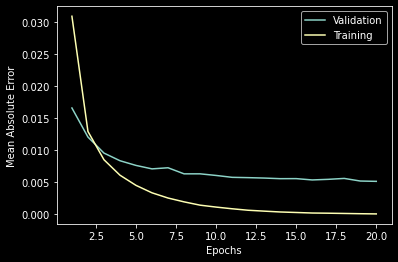

In [38]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

average_train_mae_history = [
    np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, label='Validation')
plt.plot(range(1, len(average_train_mae_history) + 1), average_train_mae_history, label = 'Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [39]:
test = model.evaluate(test_images, test_labels)
test

313/313 [==============================] - 1s 2ms/step - loss: 0.1505 - accuracy: 0.9783 - mae: 0.0046


[0.15050464868545532, 0.9782999753952026, 0.004617709666490555]